In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tic_env import TictactoeEnv, OptimalPlayer
%matplotlib inline

# Tic Toc Toe environment

Our 1st game is the famous Tic Toc Toe. You can read about the game and its rules here: https://en.wikipedia.org/wiki/Tic-tac-toe

We implemented the game as an environment in the style of games in the [Python GYM library](https://gym.openai.com/). The commented source code is available in the file "tic_env.py". Here, we give a brief introduction to the environment and how it can be used.

### Initialization and attributes

You can initialize the environment / game as following:

In [2]:
env = TictactoeEnv()

Which then has the following attributes with the corresponding initial values:

In [3]:
env.__dict__

{'grid': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 0,
 'current_player': 'X'}

The game is played by two players: player 'X' and player 'O'. The attribute 'current_player' shows whose turn it is. We assume that player 'X' always plays first.

The attribute 'grid' is a 3x3 numpy array and presents the board in the real game and the state $s_t$ in the reinfocement learning language. Each elements can take a value in {0, 1, -1}:
     0 : place unmarked
     1 : place marked with X 
    -1 : place marked with O 
        
The attribute 'end' shows if the game is over or not, and the attribute 'winner' shows the winner of the game: either "X", "O", or None.  

You can use function 'render' to visualize the current position of the board:

In [4]:
env.render()

|- - -|
|- - -|
|- - -|



### Taking actions

The game environment will recieve action from two players in turn and update the grid. At each time, one player can take the action $a_t$, where $a_t$ can either be an integer between 0 to 8 or a touple, corresponding to the 9 possible.

Function 'step' is used to recieve the action of the player, update the grid:

In [5]:
env.step(2)

(array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 False,
 None)

In [6]:
env.render()

|- - X|
|- - -|
|- - -|



In [7]:
env.__dict__

{'grid': array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 1,
 'current_player': 'O'}

In [8]:
env.step((1,1))

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [9]:
env.render()

|- - X|
|- O -|
|- - -|



In [10]:
env.__dict__

{'grid': array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 2,
 'current_player': 'X'}

But not all actions are available at each time: One cannot choose a place which has been taken before. There is an error if an unavailable action is taken:

In [11]:
env.step((0,2))

ValueError: There is already a chess on position (0, 2).

### Reward

Reward is always 0 until the end of the game. When the game is over, the reward is 1 if you win the game, -1 if you lose, and 0 besides. Function 'observe' can be used after each step to recieve the new state $s_t$, whether the game is over, and the winner, and function 'reward' to get the reward value $r_t$:

In [12]:
env.observe()

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [13]:
env.reward(player='X')

0

In [14]:
env.reward(player='O')

0

An example of finishing the game:

In [15]:
env.step(0)
env.step(3)
env.step(1)

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [16]:
env.render()

|X X X|
|O O -|
|- - -|



In [17]:
env.observe()

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [18]:
env.reward(player='X')

1

In [19]:
env.reward(player='O')

-1

# Optimal policy for Tic Toc Toe environment

Fortunately, we know the exact optimal policy for Tic Toc Toe. We have implemented and $\epsilon$-greedy version of optimal polciy which you can use for the project.

In [20]:
env.reset();

In [21]:
opt_player = OptimalPlayer(epsilon = 0., player = 'X')

In [22]:
opt_player.act(env.grid)

(0, 0)

In [23]:
opt_player.player

'X'

### An example of optimal player playing against random player

In [24]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt = OptimalPlayer(epsilon=0., player=Turns[0])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            move = player_rnd.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player = ' +  Turns[0])
            print('Random player = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|- - X|
|O X -|
|X O -|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O O X|
|- X X|
|O - X|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O X X|
|O O X|
|X O X|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|O - -|
|X O X|
|- X O|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O O -|
|X X X|
|O - X|



### An example of optimal player playing against optimal player

In [25]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt_1 = OptimalPlayer(epsilon=0., player=Turns[0])
    player_opt_2 = OptimalPlayer(epsilon=0., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt_1.act(grid)
        else:
            move = player_opt_2.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player 1 = ' +  Turns[0])
            print('Optimal player 2 = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|O O X|
|X X O|
|O X X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = O
Optimal player 2 = X
|O X X|
|X O O|
|X O X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X O X|
|X O O|
|O X X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X X O|
|O O X|
|X O X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = O
Optimal player 2 = X
|X O X|
|X O O|
|O X X|



## *Q*-Learning

### 2.1 Learning from experts

In [26]:
# Constants
ALPHA = 0.05
GAMMA = 0.99
EPSILON = 0.3 # Arbitrary
DELTA = 1 # For Huber loss
E_MIN = 0.1
E_MAX = 0.8

# Helpers

# Thanks to Jeremy Zhang for the idea of how to encode the state
# https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542
def encode(S, A):
    ''' Unique encoder for a given state-action pair \n
        Params: 
            S: Represents the current state, stored in TictactoeEnv object 
            A: Represents the action to be taken, either Tuple[Int] or Int
        Returns:
            string representation of (S, A)
    '''
    if isinstance(A, tuple):
        A = A[0] * 3 + A[1]
    return f'{S.grid.reshape(9)}:{A}'

def get_legal_moves(S):
    ''' Helper for getting legal moves given state S \n
        Params:
            S: Current state, stored in TictactoeEnv object
        Returns: 
            list of legal moves
    '''
    legal_moves = []
    for i in range(9):
        if S.check_valid(i):
            legal_moves.append(i)
    return legal_moves



# TODO: Can be extended to take different policies. Currently only epsilon-greedy 
def choose_action(S, e, Q, player='X'):
    """ Choose next action given current state, epsilon and saved states \n
        Params: 
            S: Current state, TictactoeEnv object for Q-learning and torch.Tensor for Deep Q-learning
            e: Epsilon value in range [0, 1], float
            Q: Learned Q function that maps string representation (S, A) to a float. 
               Either a dict(string, float) or subclass of torch.nn.Module
        Returns: 
            Next legal action as int

    """
    actions = get_legal_moves(S)
    if np.random.uniform(0, 1) <= e:
        i = np.random.choice(len(actions))
        return actions[i]
    else:
        value_max = -9999
        if isinstance(Q, dict):
            for a in actions:
                # Get Q(S, a) from saved, or 0 if not encountered
                value = Q.get(encode(S, a), 0)
                if value > value_max:
                    value_max = value
                    A = a
        else: 
            state = grid2tensor(S.grid, player)                
            with torch.no_grad():
                # The indices of maximum Q-value represents the action
                A = torch.argmax(Q(state.double())).item()
        return A


In [27]:
def test(Q, rand, e=0):
    ''' Function for computing M_opt and M_rand \n
        Params:
            Q: Learned Q function that maps string representation (S, A) to a float,  dict[string, float] 
            rand: True if calculating M_rand and False if calculating M_opt, boolean
            e: Exploration level, should be zero, int
        Returns: 
            (num_wins - num_losses) / num_games
    '''
    rewards = []
    S = TictactoeEnv()
    for i in range(500): # Fixed number of test games
        np.random.seed(i) # Different seed for each iteration
        # int(False) = 0 => optimal player, else random player
        p = OptimalPlayer(int(rand), 'O') if i % 2 == 0 else OptimalPlayer(int(rand), 'X')
        while not S.end:
            if S.current_player != p.player:
                A = choose_action(S, e, Q)
            else:
                A = p.act(S.grid)

            grid, end, winner = S.step(A)
            if end:
                # 1 if policy wins, -1 if policy loses, else 0
                R = - S.reward(player=p.player)
                rewards.append(R)
                S.reset()
                # if winner == p.player and winner is not None and not rand:
                #     print(f'Optimal player: {p.player}, Winner: {S.winner}, Reward: {R}')
                #     S.render()
                break

    return sum(rewards)  / len(rewards)

# Function for training
# Could change the representation to take the 'afterstate' instead of state-action pairs. 
# This is more efficient, as several state-action pairs can lead to the same afterstate (Sutton & Barto, 2018)
def train(N, e=0.1, e_opt=0.5, compute_every=250, decrease_epsilon=False, dec_factor=1, 
          compute_tests=False, use_deep_learning=False, policy_net=None, target_net=None, 
          use_replay_buffer=False, memory=None, itself=True):
    """ Function for training a policy Sarsa (TODO: Expand to other algorithm if needed) \n
        Params:
            N: Number of games, int
            e: Epsilon value, float in [0, 1]
            e_opt: Epsilon value for OptimalPlayer, float in [0, 1]
            compute_every: Number of games before compute training and test average, int
            decrease_epsilon: True if epsilon should be decreased each game, boolean
            dec_factor: Decreasing factor for epsilon, int
            compute_tests: True if M_opt and M_rand should be computed, boolean
            itself: True if the algorithm should learn by playing itself
        Returns: 
            three lists as a tuple. Training rewards, M_opt and m_rand,
            averaged over buckets of size compute_every 
    """
    if use_deep_learning and (policy_net is None or target_net is None):
        raise Exception("Need both Policy Net and Target Net when performing Deep Q-learning!")
    if use_replay_buffer and memory is None:
        raise Exception("Need to specify memory buffer if using replay buffer!")
    Q = {}
    S = TictactoeEnv() # Init env
    avg_rewards = [0] * (not use_deep_learning)
    curr_rewards = []
    m_opt, m_rand = [0] * (not use_deep_learning), [0] * (not use_deep_learning)
    # For Deep Q-learning
    avg_losses = [0] * (not use_deep_learning)
    curr_losses = []
    for i in range(N): 
        if i % 5000 == 0:
            print(f'Starting game {i}')
        # Compute reward (and test)
        if i % compute_every == 0 and i > 0:
            avg_rewards.append(np.mean(curr_rewards))
            curr_rewards = []
            if use_deep_learning:
                avg_losses.append(np.mean(curr_losses))
                curr_losses = []

            if compute_tests:
                m_opt.append(test(Q, False))
                m_rand.append(test(Q, True))
        # Decrease epsilon
        if decrease_epsilon:
            e = max(E_MIN, E_MAX*(1 - i / dec_factor))

        # Switch starting player
        opt = OptimalPlayer(e_opt, 'O') if i % 2 == 0 else OptimalPlayer(e_opt, 'X')

        # Keep track of explored states, 
        # along with the action and the following next state (for Deep Q-learning)
        states = []
        next_states = []
        actions = []
        

        # Play game
        while not S.end:
            
            # Our turn
            if S.current_player != opt.player:
                # Convert state to neural net input format if using Deep Q-learning
                if use_deep_learning:
                    A = choose_action(S, e, policy_net, S.current_player)
                    state = grid2tensor(S.grid, S.current_player)
                    states.append(state)
                    if use_replay_buffer:
                        actions.append(A)
                    
                else:
                    A = choose_action(S, e, Q)
                    state_action = encode(S, A)
                    states.append(state_action)

            # Optimal algorithm's turn
            else:
                if itself:
                    A = choose_action(S, e, Q)
                    state_action = encode(S, A)
                    states.append(state_action)
                else: 
                    A = opt.act(S.grid)
            # Store whether the action is valid 
            valid_action = S.check_valid(A)

            # Perform action if valid 
            if valid_action:
                grid, end, winner = S.step(A)
                # Only needed when using replay buffer
                if use_replay_buffer and S.current_player != opt.player:
                    next_state = grid2tensor(grid, S.current_player)
                    next_states.append(next_state)
            # If action not valid and using replay buffer
            elif use_replay_buffer and S.current_player != opt.player: 
                next_state = None
                next_states.append(next_state)
                end = True
            
            if end:
                # Calculate and store our reward
                if valid_action:
                    R = - S.reward(player=opt.player) 
                else:
                    R = -1
                curr_rewards.append(R) 

                # Convert to tensor if using Deep Q-learning
                if use_deep_learning:
                    R = torch.tensor([R])
                    

                # Backward propagate the reward through our state-action pairs
                if use_deep_learning and use_replay_buffer:
                    # Usikker om dette blir riktig for å lagre rewards
                    for (state, next_state), action in zip(zip(reversed(states), reversed(next_states)), reversed(actions)):
                        action = torch.tensor([action]).view(1, 1) # Wrap in torch.tensor
                        memory.push(state, action, next_state, R) # Push to memory
                        R = R * GAMMA # Discount R
                    # Perform model optimization
                    loss = optimize_model(policy_net, target_net, memory)
                    # If memory queue is smaller than BATCH_SIZE, optimize_model returns None
                    # We skip these cases
                    if loss is not None:
                        curr_losses.append(loss.item())
                    # Perform target model update
                    if i % TARGET_UPDATE == 0:
                        target_net.load_state_dict(policy_net.state_dict())

                else:          
                    next_Q = None # Next state
                    for S_A in reversed(states):
                        value = Q.get(S_A, 0)
                        if next_Q is None:
                            Q[S_A] = value + ALPHA * (R - value)
                        else:
                            Q[S_A] = value + ALPHA * (R + GAMMA * next_Q - value)
                        next_Q = Q[S_A]
                #S.render()

                # Reset and start new game
                S.reset()
                break
    
    return avg_rewards, m_opt, m_rand, avg_losses, Q

def plot_subplots(rows, cols, x, ys, hyperparam, suptitle, 
                  xlabel, ylabel, labels=[], legend_title='', subtitle=''):
    """ Function for plotting subplots
        Params: 
            (rows, cols): subplot format, (int, int)
            x: values of x-axis, iterable
            ys: values to be plotted, ndarray. MUST have shape: (num_subplots, num_labels, len(x))
                Example: If plotting both M_opt and M_rand in each subplot, num_labels=2
            hyperparam: Hyperparameter that differs over subplots, float
            suptitle: Super title, string
            xlabel: Label of x-axis, string
            ylabel: Label of y-axis, string
            labels: Labels, optional iterable of length num_labels
            legend_title: Optional legend title, str
            subtitle: optional (generic) subtitle of each subplot, is combined with hyperparam. string. 
    """

    fig, axs = plt.subplots(rows, cols, figsize=(20, 20), sharex=True, sharey=True)
    axs = axs.flatten()

    # Reveal x-ticks and y-ticks on all subplots -> Doesnt work
    for ax in axs:
        for (x_tick, y_tick) in zip(ax.get_xticklabels(), ax.get_yticklabels()):
            x_tick.set_visible(True)
            y_tick.set_visible(True)

    # Plot
    plt.suptitle(suptitle, fontsize=30)
    for i, (hp, y) in enumerate(zip(hyperparam, ys)):
        for reward in y:   
            sns.lineplot(x=x, y=reward, ax=axs[i])
        axs[i].set_title(f'{subtitle} = {hp}', fontsize=24)
        if labels != []:
            axs[i].legend(title=legend_title, labels=labels, loc='lower right')

    fig.text(0.5, 0.04, xlabel, ha='center', fontsize=26)
    fig.text(0.04, 0.5, ylabel, va='center', rotation='vertical', fontsize=26)

#### Question 1

-> Used sanity check opt = OptimalPlayer(0, _)
TODO: Add caption

Text(0, 0.5, 'Avg. reward for past 250 games')

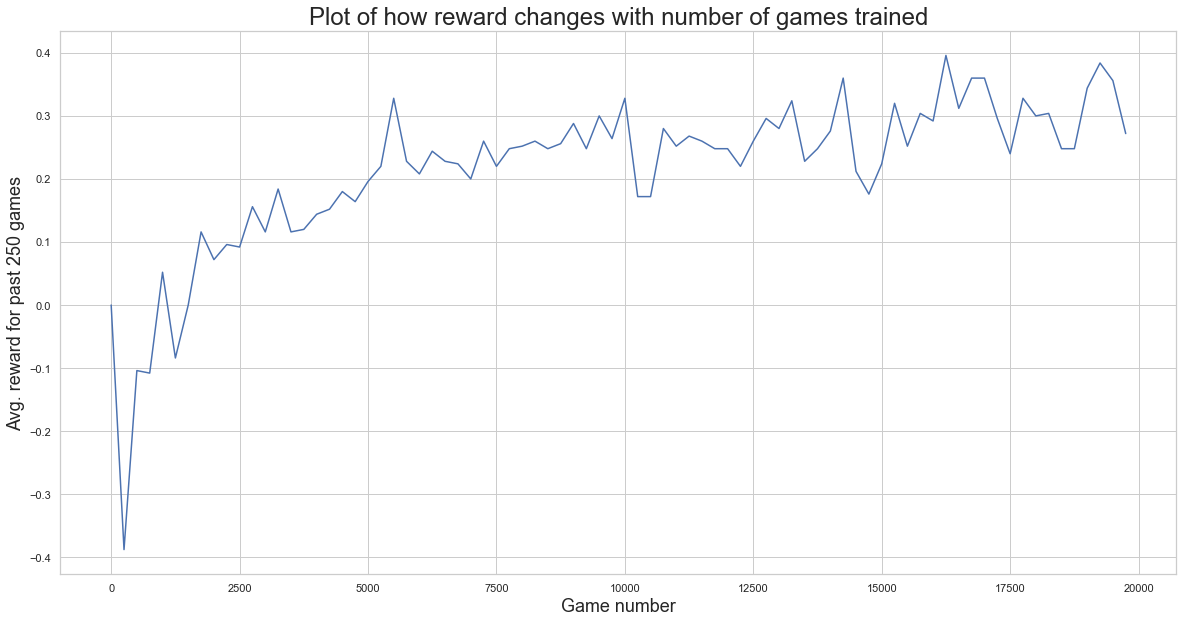

In [30]:
rewards, _, _, _ = train(20000, e=0.1)

fig = plt.figure(figsize=(20, 10))
sns.set_theme(style='whitegrid')
X = np.linspace(0, 19750, 20000 // 250)
sns.lineplot(x=X, y=rewards)
plt.title('Plot of how reward changes with number of games trained', fontsize=24)
plt.xlabel('Game number', fontsize=18)
plt.ylabel('Avg. reward for past 250 games', fontsize=18)


### 2.1.1 Decreasing exploration

#### Question 2

In [ ]:
### 2.1.1 Decreasing exploration
# Eight different values of the decrease factors
dec_factors = [1] + [i * 5000 for i in range(1, 9)]
rewards = []

for dec_factor in dec_factors:
    dec_rewards, _, _, _, hist = train(20000, dec_factor=dec_factor, decrease_epsilon=True)
    rewards.append(dec_rewards)

# Expand dims for plotting function
rewards = np.expand_dims(rewards, 1)

Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000


KeyboardInterrupt: 

In [ ]:
rewards, _, _, _, hist = train(20000, dec_factor=dec_factor, decrease_epsilon=True)

Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


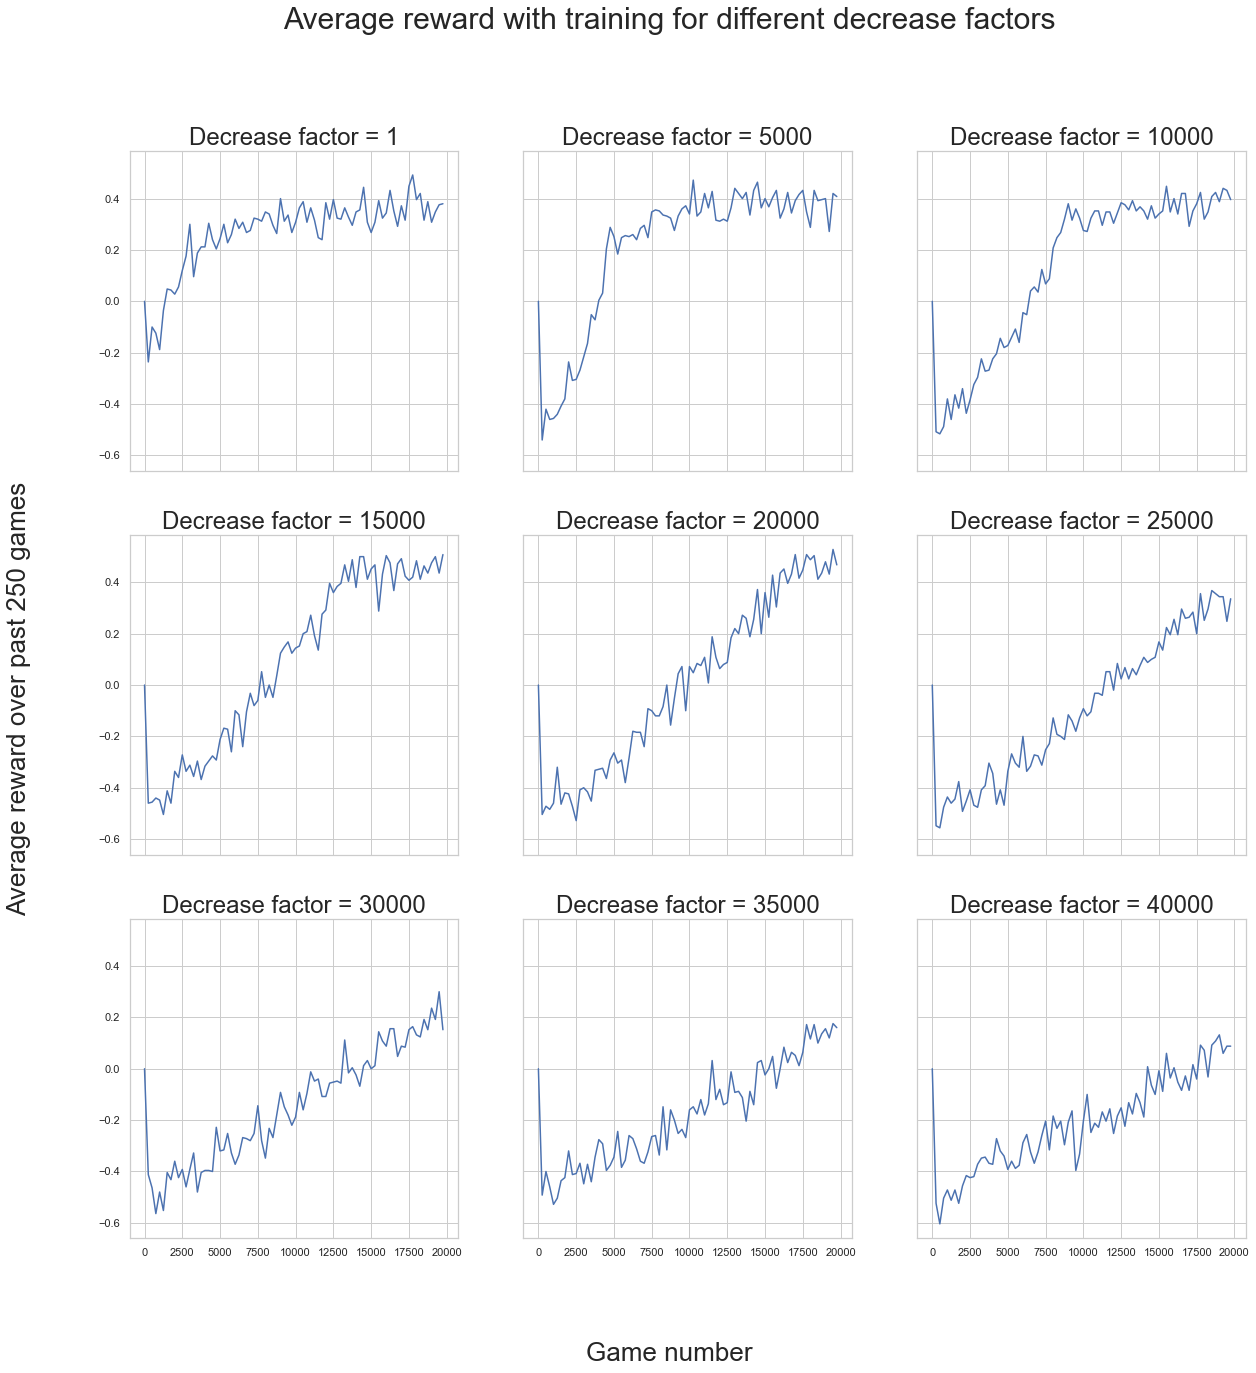

In [ ]:
suptitle = 'Average reward with training for different decrease factors'
subtitle = 'Decrease factor'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
#rewards = np.expand_dims(rewards, 1)
plot_subplots(3, 3, X, rewards, dec_factors, suptitle, 
              xlabel, ylabel, subtitle=subtitle)

The larger $n^*$ is, the longer the algorithm stays in 'exploration' mode, i.e. it will keep a higher value of $\epsilon$ for a longer time. From the plots above it is clear that as $n^*$ grows, the speed of which the algorithm converges slows down. For the $n^* \in [15000, 20000]$, the convergence speed is lower than for the smaller $n^*$, but the eventual reward is larger. 

A correct choice of $\epsilon$ helps training. For the example above, $n^* \in [1, 5000, 10000]$ greatly speeds up training, while $n^* \in [15000, 20000]$ seems to increase convergence treshold. Larger values of $\epsilon$ slows down training, as the algorithm has a higher emphasize on exploration.

#### Question 3

In [ ]:
dec_factors = [1] + [i * 5000 for i in range(1, 9)]
m_opts, m_rands = [], []

for dec_factor in dec_factors:
    _, m_opt, m_rand, _ = train(20000, dec_factor=dec_factor, decrease_epsilon=True, compute_tests=True)
    m_opts.append(m_opt)
    m_rands.append(m_rand)

# Format and stack along axis=1
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)
m = np.hstack([m_opts, m_rands])

Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


TypeError: _vhstack_dispatcher() got an unexpected keyword argument 'axis'

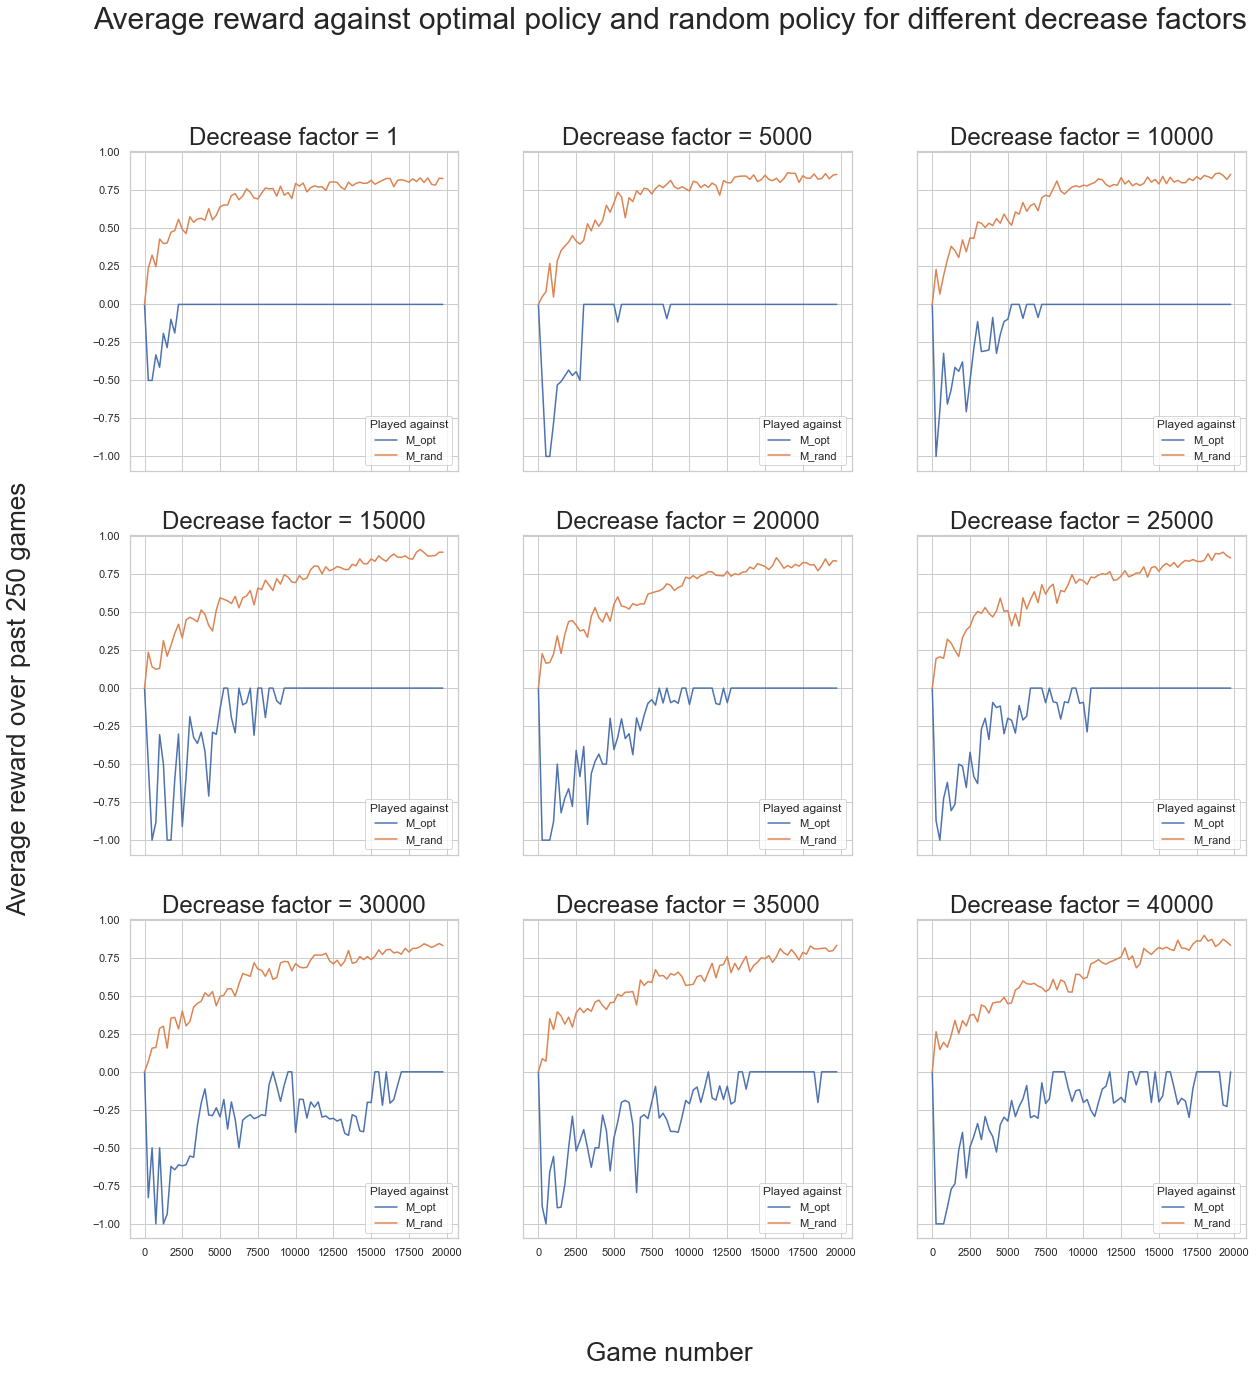

In [ ]:
suptitle = 'Average reward against optimal policy and random policy for different decrease factors'
subtitle = 'Decrease factor'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
plot_subplots(3, 3, X, m, dec_factors, suptitle, xlabel, ylabel, labels=['M_opt', 'M_rand'], 
              legend_title='Played against', subtitle=subtitle)


### 2.1.2 Good experts and bad experts

Choosing $n^*$ = 20000 as this value yields the highest average reward after 20000 games.

We further pick ${\epsilon}_{opt}$ from $[0, 0.1, 0.2, 0.4, 0.6, 0.8]$. 

#### Question 4

In [ ]:
e_opts = [0, 0.1, 0.2, 0.4, 0.6, 0.8]
m_opts, m_rands = [], []

for e_opt in e_opts:
    _, m_opt, m_rand, _ = train(20000, e_opt=e_opt, dec_factor=20000, decrease_epsilon=True, compute_tests=True)
    m_opts.append(m_opt)
    m_rands.append(m_rand)

# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])


Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


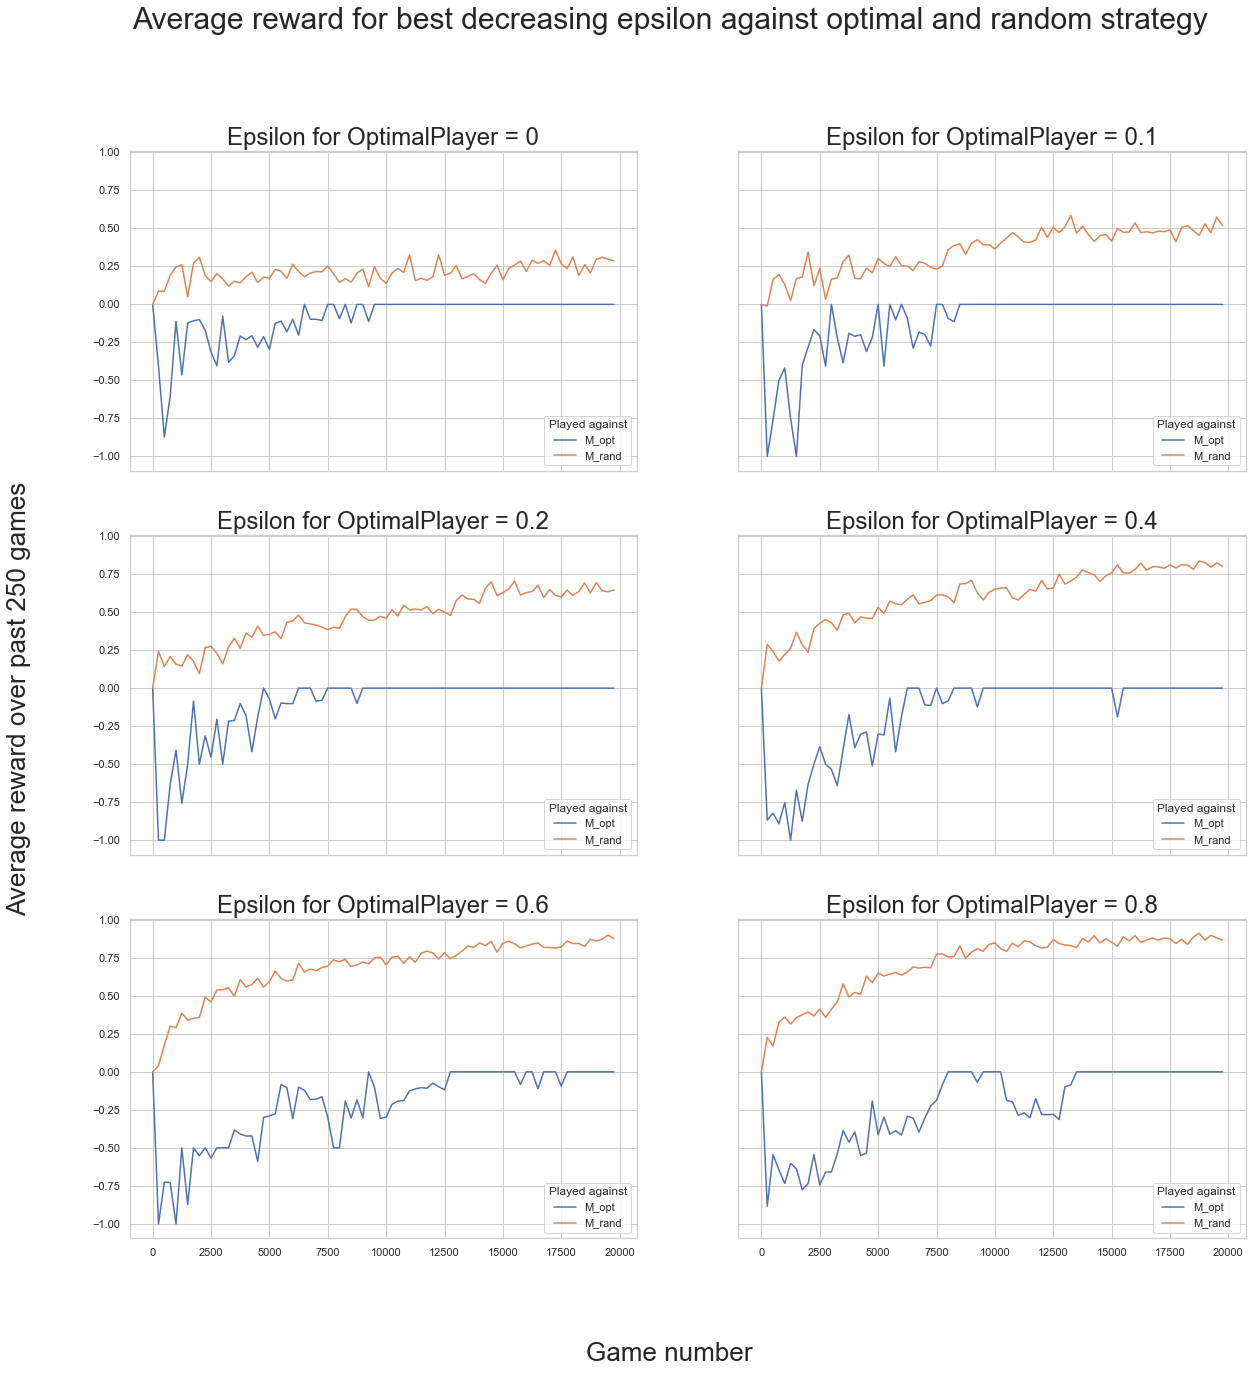

In [ ]:
suptitle = 'Average reward for best decreasing epsilon against optimal and random strategy'
subtitle = 'Epsilon for OptimalPlayer'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
plot_subplots(3, 2, X, m, e_opts, suptitle, xlabel, ylabel,
              labels=['M_opt', 'M_rand'], legend_title='Played against',
              subtitle=subtitle)

#### Question 5

In [ ]:
max_m_opts = np.max(m_opts.reshape((m_opts.shape[0], m_opts.shape[2])))
max_m_rands = np.max(m_rands.reshape((m_rands.shape[0], m_rands.shape[2])))

print('The largest values of M_opt and M_rand are:')
print(f'M_opt: {max_m_opts}')
print(f'M_rand: {max_m_rands}')

The largest values of M_opt and M_rand are:
M_opt: 0.0
M_rand: 0.912


#### Question 6

(Theory) Assume that Agent 1 learns by playing against Opt(0) and find the optimal Q- values Q1(s, a). In addition, assume that Agent 2 learns by playing against Opt(1) and find the optimal Q-values Q2(s, a). Do Q1(s, a) and Q2(s, a) have the same values? Justify your answer. (answer length < 150 words)

Agent 1 and Agent 2 will almost always have different values (or will they eventuelly converge to the same?). Opt(0) will always play an optimal strategy, whereas Opt(1) will play randomly. Therefore, Opt(1) will explore 

#### Question 7

In [31]:
e_s = [0, 0.25, 0.75, 1]
m_opts, m_rands = [], []

for e in e_s:
    _, m_opt, m_rand, _ = train(20000, e=e, decrease_epsilon=False, compute_tests=True)
    m_opts.append(m_opt)
    m_rands.append(m_rand)

# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])


Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


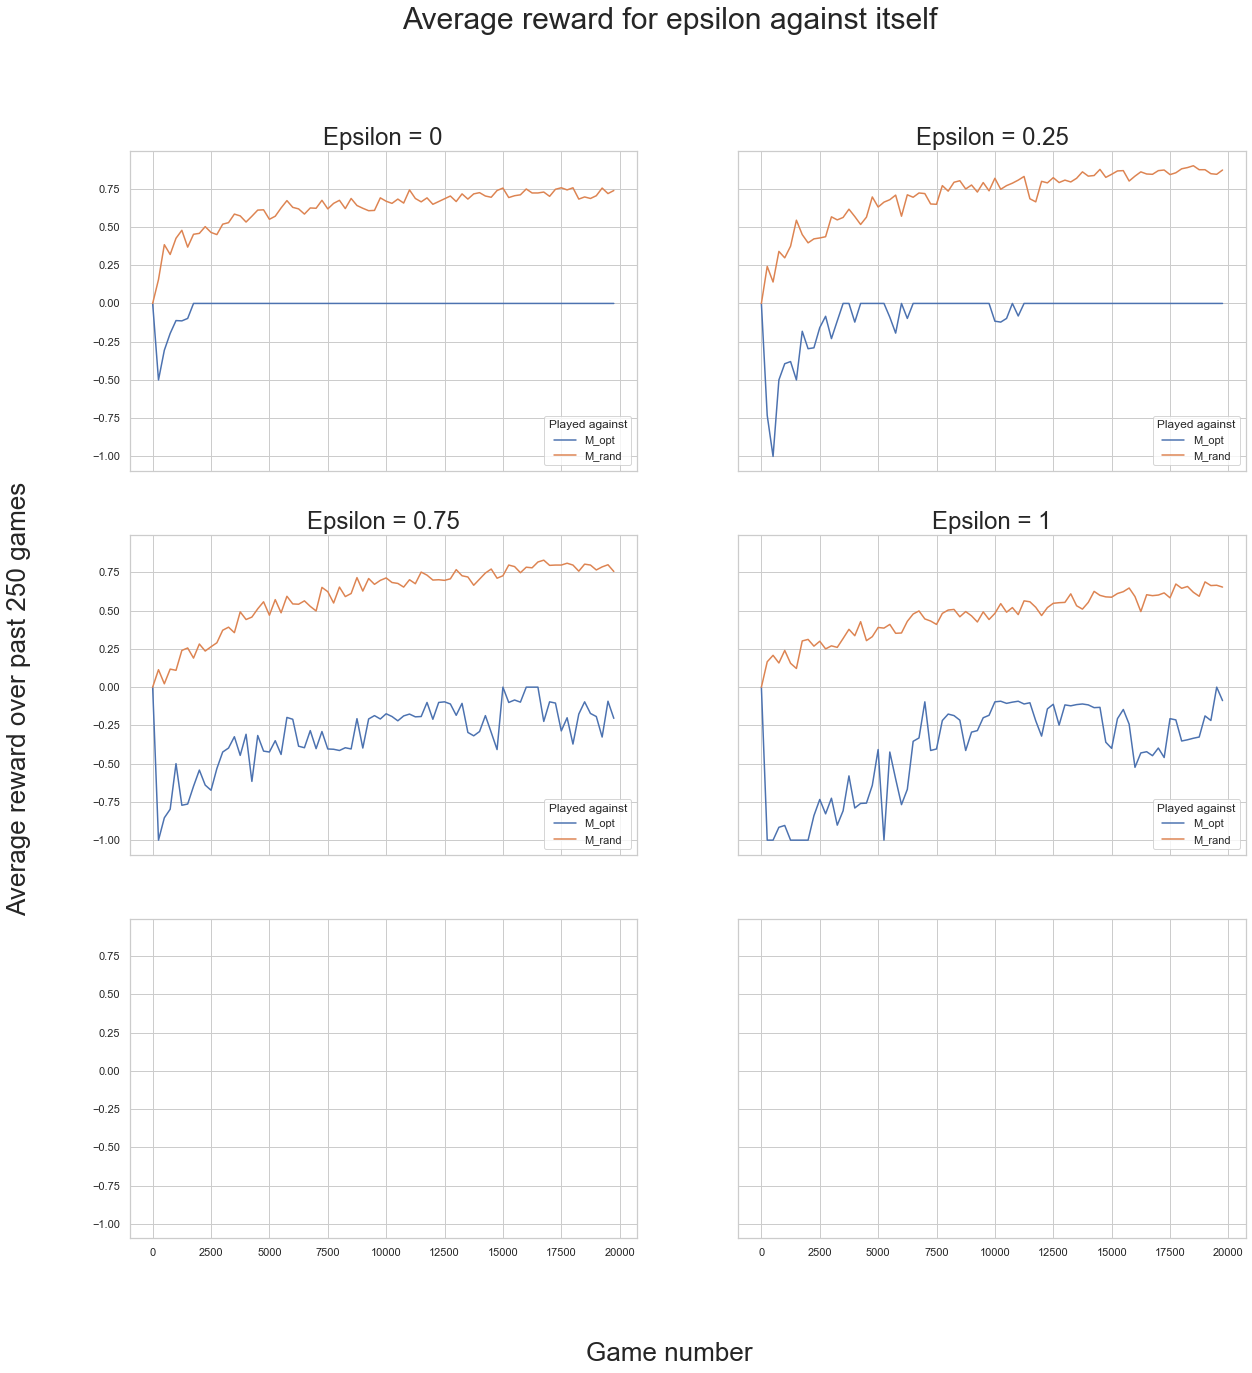

In [32]:
suptitle = 'Average reward for epsilon against itself'
subtitle = 'Epsilon'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
plot_subplots(3, 2, X, m, e_s, suptitle, xlabel, ylabel,
              labels=['M_opt', 'M_rand'], legend_title='Played against',
              subtitle=subtitle)

#### Question 8

In [35]:
dec_factors = [1, 10000, 20000, 40000]
m_opts, m_rands = [], []

for dec in dec_factors:
    _, m_opt, m_rand, _, Q = train(20000, e=e, dec_factor=dec, decrease_epsilon=True, compute_tests=True)
    m_opts.append(m_opt)
    m_rands.append(m_rand)

# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])


Starting game 0
Starting game 5000
Starting game 10000


In [ ]:
suptitle = 'Average reward for values of N* against itself'
subtitle = 'N*'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
plot_subplots(3, 2, X, m, dec_factors, suptitle, xlabel, ylabel,
              labels=['M_opt', 'M_rand'], legend_title='Played against',
              subtitle=subtitle)

#### Question 9

In [ ]:
max_m_opts = np.max(m_opts.reshape((m_opts.shape[0], m_opts.shape[2])))
max_m_rands = np.max(m_rands.reshape((m_rands.shape[0], m_rands.shape[2])))

print('The largest values of M_opt and M_rand are:')
print(f'M_opt: {max_m_opts}')
print(f'M_rand: {max_m_rands}')

#### Question 10

In [33]:
# Encoding the states we will check out
S1 = TictactoeEnv()
S2 = TictactoeEnv()
S2.step(4)
S2.step(0)
S2.step(6)
S3 = TictactoeEnv()
S3.step(3)
S3.step(4)
S3.step(5)
S3.step(2)
S3.step(6)

actions = get_legal_moves(S1)
q_values_1 = []
for a in actions:
    q_values_1.append(Q.get(encode(S1,a),0))

actions = get_legal_moves(S2)
q_values_2 = []
for a in actions:
    q_values_2.append(Q.get(encode(S2,a),0))

actions = get_legal_moves(S3)
q_values_3 = []
for a in actions:
    q_values_3.append(Q.get(encode(S3,a),0))

NameError: name 'Q' is not defined

In [ ]:
import seaborn as sns

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(26,8))
g1 = sns.heatmap(q_values_1,cmap="YlGnBu", cbar=False,ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g2 = sns.heatmap(q_values_2,cmap="YlGnBu", cbar=False,ax=ax2)
ax2.text(1.4, 1.6, 'X', fontsize=48)
ax2.text(0.4, 0.6, 'O', fontsize=48)
ax2.text(0.4, 2.6, 'X', fontsize=48)
g2.set_ylabel('')
g2.set_xlabel('')
g3 = sns.heatmap(q_values_3,cmap="YlGnBu", annot=True, annot_kws={'fontsize':'xx-large'}, cbar=False, ax=ax3)
ax3.text(2.4, 1.6, 'X', fontsize=48)
ax3.text(0.4, 1.6, 'X', fontsize=48)
ax3.text(0.4, 2.6, 'X', fontsize=48)
ax3.text(1.4, 1.6, 'O', fontsize=48)
ax3.text(2.4, 0.6, 'O', fontsize=48)
g3.set_ylabel('')
g3.set_xlabel('')


## Deep *Q*-Learning

In [4]:
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The following part sets up the model architecture as described in [this](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) pytorch tutorial:


In [74]:
# Framework for Replay Memory that stores transitions in games

Transition = namedtuple(
    'Transition', 
    ('state', 'action', 
    'next_state', 'reward')
)

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Saves transition(s)"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self): 
        return len(self.memory)

In [116]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()

        # Define hidden layers and add Batch Normalization as we're using ReLu
        self.l1 = nn.Linear(in_features=3*3*2, out_features=128)
        #self.bn1 = nn.BatchNorm1d(128)
        self.l2 = nn.Linear(in_features=128, out_features=128)
        #self.bn2 = nn.BatchNorm1d(128)
        
        self.l3 = nn.Linear(in_features=128, out_features=9)

    def forward(self, x):
        x = x.to(device)
        # Apply BN after ReLu
        x = F.selu(self.l1(x.double()))
        #x = self.bn1(x[None]) #Doesn't work for batchsize=1. Maybe switch to SeLu
        x = F.selu(self.l2(x))
        x = self.l3(x)
        return x
        
# Changing from ReLu to SeLu increased reward score


In [117]:
BATCH_SIZE = 64 # Take batches of 64
TARGET_UPDATE = 500 # Update every 500 game

policy_net = DQN().to(device).double()
target_net = DQN().to(device).double()

memory = ReplayMemory(10000)

In [118]:
def optimize_model(policy_net, target_net, memory):
    if len(memory) < BATCH_SIZE:
        return # Do nothing

    # Use Adam optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

    # Get batch-array of transitions, and convert to Transition of batch-arrays
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Mask of non-final states
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), 
        device=device
    )

    # Non-final states
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # Unpack batch
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Action taken from policy for each state
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute values for next state based on target_net, zero if final
    next_state_values = torch.zeros(BATCH_SIZE, device=device, dtype=torch.double)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()


    # Expected Q--values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber loss (delta defaults to 1)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))


    # Optimize
    optimizer.zero_grad()
    loss.backward()
    for i, param in enumerate(policy_net.parameters()):
        if param.grad is not None:
            param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss

In [119]:
def grid2tensor(grid, player):
    # Flattened representation of each players positions
    result = np.zeros((9, 2))
    # Convert player to integer
    player_value = 1 if player == 'X' else -1
    # Retrieve indices of both players positions
    player_mask = np.where(grid.ravel() == player_value)[0]
    opposition_mask = np.where(grid.ravel() == - player_value)[0]
    # Insert values into final result
    result[player_mask, 0] = 1
    result[opposition_mask, 1] = 1
    # Reshape to shape expected by neural network and convert to tensor
    return torch.from_numpy(result.reshape(18))[None]

#### Question 11

In [120]:
rewards, _, _, losses = train(20000, use_deep_learning=True, policy_net=policy_net, target_net=target_net, use_replay_buffer=True, memory=memory)

Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


In [123]:
len(X)

80

Text(0, 0.5, 'Average loss')

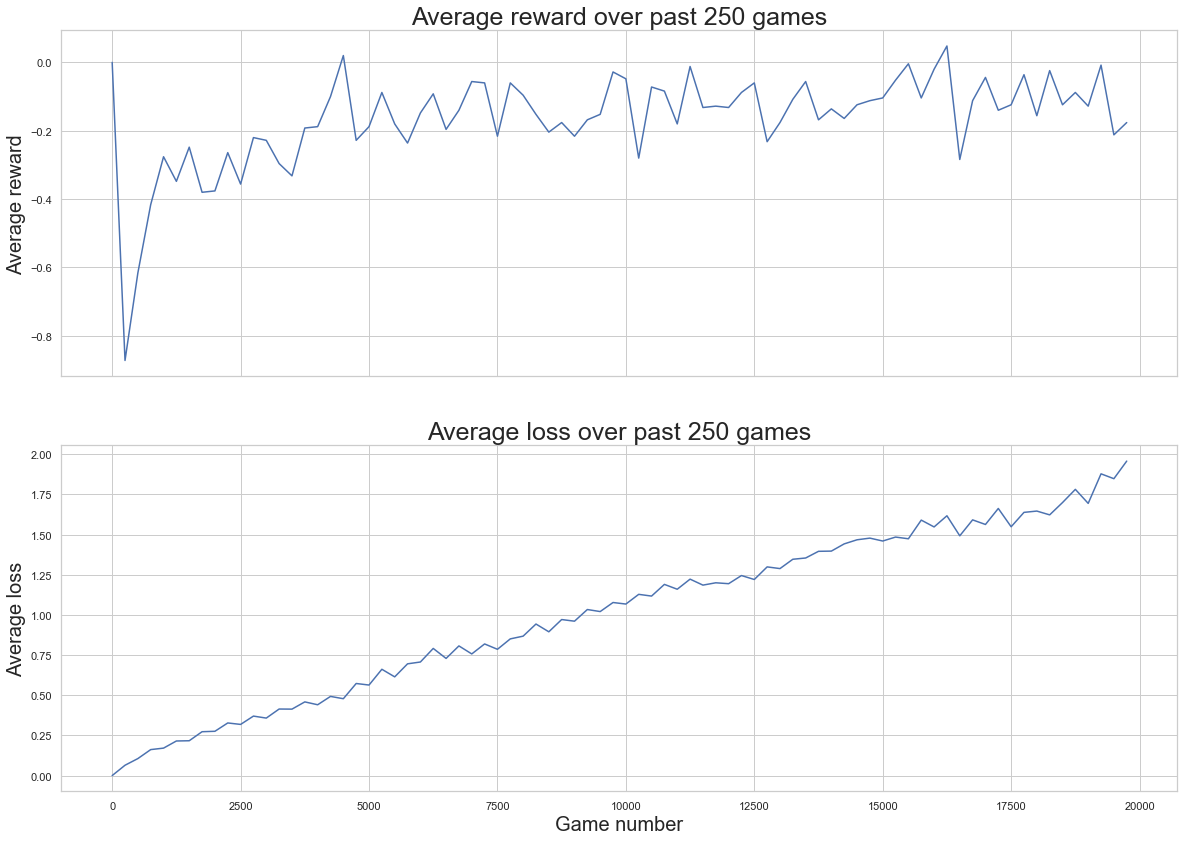

In [124]:
fig, axs = plt.subplots(2, 1, figsize=(20, 14), sharex=True)
sns.set_theme(style='whitegrid')
X = np.linspace(0, 19750, 20000 // 250)
plt.xlabel('Game number', fontsize=20)
plt.ylabel('Avg. reward for past 250 games', fontsize=18)

sns.lineplot(x=X, y=[0]+rewards, ax=axs[0])
sns.lineplot(x=X, y=[0]+losses, ax=axs[1])

axs[0].set_title('Average reward over past 250 games', fontsize=25)
axs[1].set_title('Average loss over past 250 games', fontsize=25)

axs[0].set_ylabel('Average reward', fontsize=20)
axs[1].set_ylabel('Average loss', fontsize=20)





